# 0. Dependências

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('max_columns', 100)

%matplotlib inline

In [2]:
COL_ANSWER = ['variacao_preco']
COLS_FEATURES = ['pontos', 'preco', 'media_pontos']
COLS_EXTRA = ['id', 'rodada']
COLS_OF_INTEREST = COLS_EXTRA + COLS_FEATURES + COL_ANSWER

# 1. Análise dos Dados

In [3]:
df = pd.read_csv('../../../data/desafio_valorizacao/valorizacao_cartola_2018.csv')
print(df.shape)

df.head()

(30955, 33)


,n,nome_completo,slug,apelido,foto,id,rodada,id_time,posicao,status,pontos,preco,variacao_preco,media_pontos,nome_time,CA,FC,FS,GC,I,PE,RB,SG,FF,FD,G,DD,GS,A,FT,CV,DP,PP
0,7,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,38,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,37,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,36,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,35,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,Juan Silveira dos Santos,juan,Juan,https://s.glbimg.com/es/sde/f/2018/05/04/a27fb...,36540,34,FLA,zag,Contundido,0.0,5.74,0.0,1.55,262,1.0,1.0,1.0,NaN,NaN,7.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df[COLS_OF_INTEREST]
print(df.shape)

df.head()

(30955, 6)


,id,rodada,pontos,preco,media_pontos,variacao_preco
0,36540,38,0.0,5.74,1.55,0.0
1,36540,37,0.0,5.74,1.55,0.0
2,36540,36,0.0,5.74,1.55,0.0
3,36540,35,0.0,5.74,1.55,0.0
4,36540,34,0.0,5.74,1.55,0.0


In [5]:
df.isna().any()

id                False
rodada            False
pontos            False
preco             False
media_pontos      False
variacao_preco    False
dtype: bool

# 2. Criação das Amostras

In [6]:
%%time
df_samples = pd.DataFrame([])

for rodada in range(1, 38):
    df_rod_atual = df[df.rodada == rodada]
    df_rod_prox = df[df.rodada == (rodada + 1)]
    df_merge = df_rod_atual.merge(df_rod_prox[['id', 'variacao_preco']] , how='left', on='id', suffixes=('_atual', '_prox'))
    df_merge = df_merge.dropna()
    df_merge = df_merge[(df_merge.variacao_preco_atual != 0) & (df_merge.variacao_preco_prox != 0)]
    df_samples = df_samples.append(df_merge)
    
print(df_samples.shape)

(7748, 7)
CPU times: user 414 ms, sys: 14.3 ms, total: 429 ms
Wall time: 434 ms


In [7]:
# random_player = np.random.choice(df.id.unique())
random_player = 83786

df_samples[df_samples.id == 83786].sort_values(by='rodada')

,id,rodada,pontos,preco,media_pontos,variacao_preco_atual,variacao_preco_prox
365,83786,6,7.7,5.55,7.7,0.55,0.85
363,83786,7,8.3,6.40,8.0,0.85,-2.31


In [8]:
df[df.id == random_player].sort_values(by='rodada')

,id,rodada,pontos,preco,media_pontos,variacao_preco
13751,83786,1,0.0,5.00,0.00,0.00
13750,83786,2,0.0,5.00,0.00,0.00
13749,83786,3,0.0,5.00,0.00,0.00
13748,83786,4,0.0,5.00,0.00,0.00
13747,83786,5,0.0,5.00,0.00,0.00
13746,83786,6,7.7,5.55,7.70,0.55
13745,83786,7,8.3,6.40,8.00,0.85
13744,83786,8,-4.5,4.09,3.83,-2.31
13743,83786,9,0.0,4.09,3.83,0.00
13742,83786,10,0.0,4.09,3.83,0.00


# 3. Treinamento do Modelo

In [9]:
x = df_samples.drop(columns=COLS_EXTRA + ['variacao_preco_prox']).values
y = df_samples['variacao_preco_prox'].values.reshape(-1, 1)

print(x.shape, y.shape)

(7748, 4) (7748, 1)


In [10]:
std = StandardScaler()
x = std.fit_transform(x)

In [11]:
reg = LinearRegression()
reg.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

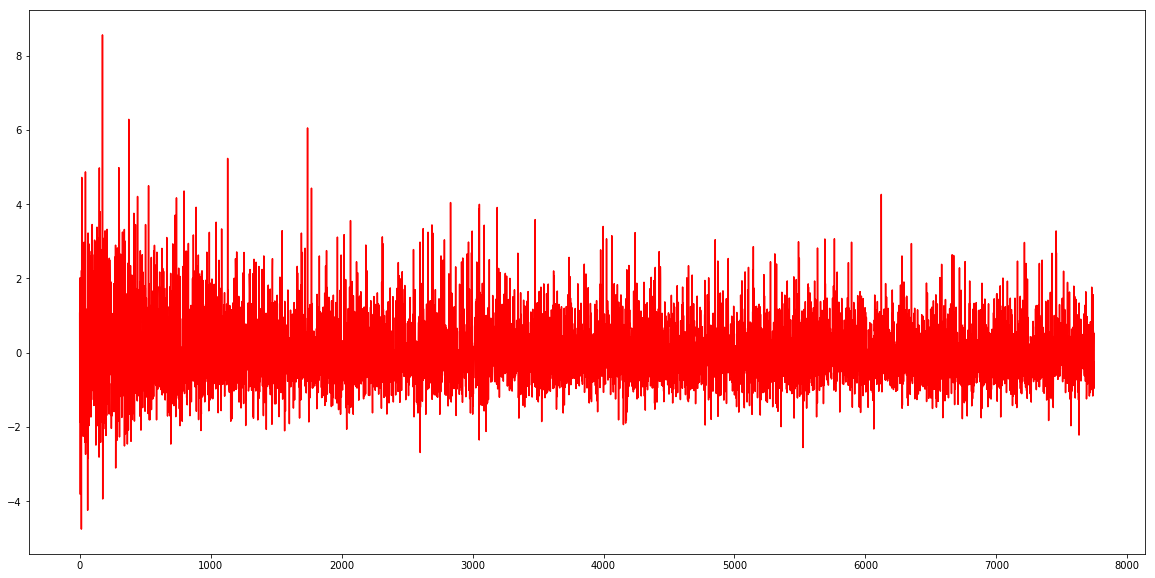

In [12]:
y_pred = reg.predict(x)
diff = y - y_pred

plt.figure(figsize=(20, 10))
plt.plot(diff, color='red')

In [13]:
mean_squared_error(y, y_pred)

0.812932960367022

In [14]:
r2_score(y, y_pred)

0.24562492965746774

In [15]:
diff.mean(), diff.std()

(1.1004791983894168e-17, 0.9016279500808646)

In [16]:
print(reg.coef_)
print(reg.intercept_)

[[-0.66194991 -0.0144356   0.1797207   0.11751423]]
[0.04618482]
